In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#import necessary libraries
import os 
import re
import sys
import shutil
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

In [ ]:

import requests
from tqdm.auto import tqdm
# Function to download data
def zindi_data_downloader(url, token, file_name):
    # Get the competition data
    competition_data = requests.post(url = data_url, data= token, stream=True)
    
    # Progress bar monitor download
    pbar = tqdm(desc=file_name, total=int(competition_data.headers.get('content-length', 0)), unit='B', unit_scale=True, unit_divisor=512)
    # Create and Write the data to colab drive in chunks
    handle = open(file_name, "wb")
    for chunk in competition_data.iter_content(chunk_size=512): # Download the data in chunks
        if chunk: # filter out keep-alive new chunks
                handle.write(chunk)
        pbar.update(len(chunk))
    handle.close()
    pbar.close()
    
# Data url, token and file_name
data_url = "https://api.zindi.africa/v1/competitions/datafest-africa-2022/files/AUDIO_CLIPS.zip"
token = {'auth_token': 'CkT6GWnNRSAWGDKhSz3PPsfT'} # Use your own token
file_name = 'Data_Fest_Challenge_audio_clips.zip'
# Download data
zindi_data_downloader(url = data_url, token = token, file_name = file_name)
# Unzip data
!unzip -q /content/Data_Fest_Challenge_audio_clips.zip

Data_Fest_Challenge_audio_clips.zip:   0%|          | 0.00/89.7G [00:00<?, ?B/s]

In [ ]:
#install librosa library used for audio processing
!pip install librosa

In [ ]:
import pandas as pd
#Reading the train and test datasets
train_data=pd.read_csv('/content/gdrive/MyDrive/Data_fest_competition/Train_sound.csv',na_values='NULL')
test_data=pd.read_csv('/content/gdrive/MyDrive/Data_fest_competition/Test_sound.csv',na_values='NULL')

In [ ]:
train_data.head()

,CLIP_ID,category
0,ID_RX0ERYVE,school
1,ID_RG7TUTFN,boda-boda-motocyle
2,ID_XQ2O77I0,bar-restaurant-nightclub
3,ID_K5G9YVJS,generator
4,ID_S2W5EPQP,community-radio


In [ ]:
train_data['category'].value_counts()

fabrication-workshop        1916
school                      1814
regilious-venue             1732
animal                      1724
community-radio             1666
construction-site           1646
car-alarm                   1595
car-or-truck                1566
bar-restaurant-nightclub    1562
motorvehicle-horn           1546
street-preacher             1540
hawker-vendor               1539
crowd-noise                 1538
herbalists                  1537
boda-boda-motocyle          1525
generator                   1462
mobile-music                1199
motorvehicle-siren           931
other                        917
Name: category, dtype: int64

In [ ]:
!pip install Ipython

In [ ]:
import librosa
import glob
import IPython.display as ipd
%pylab inline

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


Populating the interactive namespace from numpy and matplotlib


Taking a look at some of the audio files

In [ ]:
ipd.Audio('AUDIO_CLIPS/ID_RX0ERYVE.wav')

In [ ]:
ipd.Audio('AUDIO_CLIPS/ID_RG7TUTFN.wav')

In [ ]:
ipd.Audio('AUDIO_CLIPS/ID_XQ2O77I0.wav')

In [ ]:
ipd.Audio('AUDIO_CLIPS/ID_K5G9YVJS.wav')

EXPLORATORY DATA ANALYSIS

In [ ]:
data, sample_rate = librosa.load('AUDIO_CLIPS/ID_K5G9YVJS.wav')

In [ ]:
sample_rate

22050

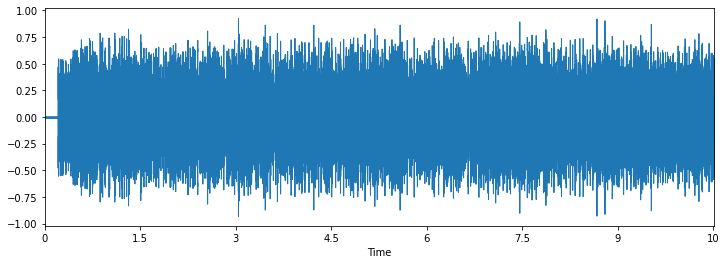

In [ ]:
#Visualize a noise wave
import librosa.display
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sr=sample_rate)

FEATURE EXTRACTION

In [ ]:
#appending .wav to the clip IDs
train_data["CLIP_ID"]=train_data["CLIP_ID"]+'.wav'

In [ ]:
train_data.head()

,CLIP_ID,category
0,ID_RX0ERYVE.wav,school
1,ID_RG7TUTFN.wav,boda-boda-motocyle
2,ID_XQ2O77I0.wav,bar-restaurant-nightclub
3,ID_K5G9YVJS.wav,generator
4,ID_S2W5EPQP.wav,community-radio


PURE MFCC FEATURES

In [ ]:
#extract mel-frequency cepstral coefficient features
def feature_extractor_mfcc(row):
  #file path
  file_name=os.path.join('AUDIO_CLIPS', str(row.CLIP_ID))
  #load the audio file
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  #extract features from the data
  mfccs= np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=120).T, axis=0)

  feature=mfccs
  label=row.category

  return [feature, label]

FEATURE MANIPULATION- MFCC-DELTA FEATURES

In [ ]:
#Function to extract mfcc-delta features with an order=1
def feature_extractor_delta(row):
  #file path
  file_name=os.path.join('AUDIO_CLIPS', str(row.CLIP_ID))
  #load the audio file
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  #extract features from the data
  mfccs= np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=60).T, axis=0)
  mfcc_delta = librosa.feature.delta(mfccs)

  feature=mfcc_delta
  label=row.category

  return [feature, label]

In [ ]:
#applying the function on the train data
train=train_data.apply(feature_extractor_delta, axis=1)
train.columns = ['feature', 'label']


In [ ]:
x= np.array(list(zip(*train))[0])
y= np.array(list(zip(*train))[1])

In [ ]:
y.shape

(28955,)

In [ ]:
x.shape

(28955, 60)

In [ ]:
train1=pd.DataFrame(x)

In [ ]:
y

array(['school', 'boda-boda-motocyle', 'bar-restaurant-nightclub', ...,
       'motorvehicle-siren', 'community-radio', 'community-radio'],
      dtype='<U24')

In [ ]:
categories=pd.DataFrame(y)

In [ ]:
categories.to_csv('/content/gdrive/MyDrive/Data_fest_competition/categories.csv', index=False)

Extracting Chroma stft

In [ ]:
#Function to extract chroma stft features 
def feature_extractor_stft(row):
  #file path
  file_name=os.path.join('AUDIO_CLIPS', str(row.CLIP_ID))
  #load the audio file
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  #extract features from the data
  stft= np.mean(librosa.feature.chroma_stft(y=x, sr=sample_rate, n_chroma=20).T, axis=0)

  feature=stft
  label=row.category

  return [feature, label]

In [ ]:
#Applying the function to the train dataset
train=train_data.apply(feature_extractor_stft, axis=1)
train.columns = ['feature', 'label']

In [ ]:
x= np.array(list(zip(*train))[0])
y= np.array(list(zip(*train))[1])

In [ ]:
x

array([[0.5248455 , 0.5113119 , 0.5303857 , ..., 0.6394745 , 0.5856989 ,
        0.5599609 ],
       [0.51910096, 0.552906  , 0.56165135, ..., 0.49428684, 0.49655408,
        0.49748325],
       [0.34226996, 0.21805358, 0.2078834 , ..., 0.3939168 , 0.36766312,
        0.37915254],
       ...,
       [0.11523787, 0.09326641, 0.11022981, ..., 0.21758609, 0.1708896 ,
        0.13901657],
       [0.45607373, 0.46633998, 0.3551772 , ..., 0.24836437, 0.2271685 ,
        0.2613624 ],
       [0.32614288, 0.398838  , 0.37119448, ..., 0.23602475, 0.24493375,
        0.28799877]], dtype=float32)

In [ ]:
train_stft=pd.DataFrame(x)

In [ ]:
train_stft.shape

(28955, 20)

In [ ]:
train_stft.to_csv('/content/gdrive/MyDrive/Data_fest_competition/train_stft_features.csv', index=False)

Extracting Chroma cqt

In [ ]:
#Function to extract chroma cqt features
def feature_extractor_cqt(row):
  #file path
  file_name=os.path.join('AUDIO_CLIPS', str(row.CLIP_ID))
  #load the audio file
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  #extract features from the data
  cqt= np.mean(librosa.feature.chroma_cqt(y=x, sr=sample_rate).T, axis=0)

  feature=cqt
  label=row.category

  return [feature, label]

In [ ]:
#Applying the function to the train dataset
train=train_data.apply(feature_extractor_cqt, axis=1)
train.columns = ['feature', 'label']

In [ ]:
x= np.array(list(zip(*train))[0])
y= np.array(list(zip(*train))[1])

In [ ]:
x

In [ ]:
train_cqt=pd.DataFrame(x)

In [ ]:
train_cqt.to_csv('/content/gdrive/MyDrive/Data_fest_competition/train_cqt_features.csv', index=False)

Extracting Chroma cens

In [ ]:
#Function to extract chroma cens features
def feature_extractor_cens(row):
  #file path
  file_name=os.path.join('AUDIO_CLIPS', str(row.CLIP_ID))
  #load the audio file
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  #extract features from the data
  cens= np.mean(librosa.feature.chroma_cens(y=x, sr=sample_rate).T, axis=0)

  feature=cens
  label=row.category

  return [feature, label]

In [ ]:
#Applying the function to the train dataset
train=train_data.apply(feature_extractor_cens, axis=1)
train.columns = ['feature', 'label']

In [ ]:
x= np.array(list(zip(*train))[0])
y= np.array(list(zip(*train))[1])

In [ ]:
x

In [ ]:
train_cens=pd.DataFrame(x)

In [ ]:
train_cens.to_csv('/content/gdrive/MyDrive/Data_fest_competition/train_cens_features.csv', index=False)

Extracting RMS Feature per frame

In [ ]:
#Function to extract RMS feature per frame
def feature_extractor_rms(row):
  #file path
  file_name=os.path.join('AUDIO_CLIPS', str(row.CLIP_ID))
  #load the audio file
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  #extract features from the data
  rms= np.mean(librosa.feature.rms(y=x).T, axis=0)

  feature=rms
  label=row.category

  return [feature, label]

In [ ]:
#Applying the function to the train dataset
train=train_data.apply(feature_extractor_rms, axis=1)
train.columns = ['feature', 'label']

In [ ]:
x= np.array(list(zip(*train))[0])
y= np.array(list(zip(*train))[1])

In [ ]:
x

In [ ]:
train_rms=pd.DataFrame(x)

In [ ]:
train_rms.to_csv('/content/gdrive/MyDrive/Data_fest_competition/train_rms_features.csv', index=False)

Extracting Spectral Centroids

In [ ]:
#Function to extract spectral centroids
def feature_extractor_centroids(row):
  #file path
  file_name=os.path.join('AUDIO_CLIPS', str(row.CLIP_ID))
  #load the audio file
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  #extract features from the data
  centroids= np.mean(librosa.feature.spectral_centroid(y=x, sr=sample_rate).T, axis=0)

  feature=centroids
  label=row.category

  return [feature, label]

In [ ]:
#Applying the function to the train dataset
train=train_data.apply(feature_extractor_centroids, axis=1)
train.columns = ['feature', 'label']

In [ ]:
x= np.array(list(zip(*train))[0])
y= np.array(list(zip(*train))[1])

In [ ]:
x

In [ ]:
train_centroid=pd.DataFrame(x)

In [ ]:
train_centroid.to_csv('/content/gdrive/MyDrive/Data_fest_competition/train_spectral_centroid_feature.csv', index=False)

Extracting Spectral Bandwidth

In [ ]:
#Function to extract Spectral bandwidth
def feature_extractor_bandwidth(row):
  #file path
  file_name=os.path.join('AUDIO_CLIPS', str(row.CLIP_ID))
  #load the audio file
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  #extract features from the data
  bandwidth= np.mean(librosa.feature.spectral_bandwidth(y=x, sr=sample_rate).T, axis=0)

  feature=bandwidth
  label=row.category

  return [feature, label]

In [ ]:
#Applying the function to the train dataset
train=train_data.apply(feature_extractor_bandwidth, axis=1)
train.columns = ['feature', 'label']

In [ ]:
x= np.array(list(zip(*train))[0])
y= np.array(list(zip(*train))[1])

In [ ]:
x

In [ ]:
train_bandwidth=pd.DataFrame(x)

In [ ]:
train_bandwidth.to_csv('/content/gdrive/MyDrive/Data_fest_competition/train_spectral_bandwidth_feature.csv', index=False)

Extracting Spectral Contrast

In [ ]:
#Function to extract spectral contrast
def feature_extractor_contrast(row):
  #file path
  file_name=os.path.join('AUDIO_CLIPS', str(row.CLIP_ID))
  #load the audio file
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  #extract features from the data
  contrast= np.mean(librosa.feature.spectral_contrast(y=x, sr=sample_rate).T, axis=0)

  feature=contrast
  label=row.category

  return [feature, label]

In [ ]:
#Applying the function to the train dataset
train=train_data.apply(feature_extractor_contrast, axis=1)
train.columns = ['feature', 'label']

In [ ]:
x= np.array(list(zip(*train))[0])
y= np.array(list(zip(*train))[1])

In [ ]:
x

In [ ]:
train_contrast=pd.DataFrame(x)

In [ ]:
train_contrast.to_csv('/content/gdrive/MyDrive/Data_fest_competition/train_spectral_contrast_feature.csv', index=False)

Extracting Spectral Flatness

In [ ]:
#Function to extract spectral flatness
def feature_extractor_flatness(row):
  #file path
  file_name=os.path.join('AUDIO_CLIPS', str(row.CLIP_ID))
  #load the audio file
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  #extract features from the data
  flatness= np.mean(librosa.feature.spectral_flatness(y=x, sr=sample_rate).T, axis=0)

  feature=flatness
  label=row.category

  return [feature, label]

In [ ]:
#Applying the function to the train dataset
train=train_data.apply(feature_extractor_flatness, axis=1)
train.columns = ['feature', 'label']

In [ ]:
x= np.array(list(zip(*train))[0])
y= np.array(list(zip(*train))[1])

In [ ]:
x

In [ ]:
train_flatness=pd.DataFrame(x)

In [ ]:
train_flatness.to_csv('/content/gdrive/MyDrive/Data_fest_competition/train_spectral_flatness_feature.csv', index=False)

Extracting Spectral Roll-off

In [ ]:
#Function to extract spectral roll-off
def feature_extractor_rolloff(row):
  #file path
  file_name=os.path.join('AUDIO_CLIPS', str(row.CLIP_ID))
  #load the audio file
  x, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
  #extract features from the data
  rolloff= np.mean(librosa.feature.spectral_rolloff(y=x, sr=sample_rate).T, axis=0)

  feature=rolloff
  label=row.category

  return [feature, label]

In [ ]:
#Applying the function to the train dataset
train=train_data.apply(feature_extractor_rolloff, axis=1)
train.columns = ['feature', 'label']

In [ ]:
x= np.array(list(zip(*train))[0])
y= np.array(list(zip(*train))[1])

In [ ]:
x

In [ ]:
train_rolloff=pd.DataFrame(x)

In [ ]:
train_rolloff.to_csv('/content/gdrive/MyDrive/Data_fest_competition/train_spectral_rolloff_feature.csv', index=False)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
le=LabelEncoder()
y=np_utils.to_categorical(le.fit_transform(y))

TEST DATA

In [ ]:
test_data.head()

,CLIP_ID
0,ID_552CT8A9
1,ID_HRMH24NR
2,ID_NOUBSOWH
3,ID_4CQI5UTV
4,ID_CRENUL8M


In [ ]:
test_data.shape

(12405, 1)

In [ ]:
#appending .wav to the Clip IDs in the test dataframe
test_data["CLIP_ID"]=test_data["CLIP_ID"]+'.wav'

MFCC FEATURES

In [ ]:
#Extracting pure mfcc features
test=test_data.apply(feature_extractor_mfcc, axis=1)
test.columns = ['feature']


In [ ]:
test1=np.array(list(zip(*test))[0])

In [ ]:
test_features=pd.DataFrame(test1)

In [ ]:
test_features.shape

(12405, 120)

In [ ]:
test_features.to_csv('/content/gdrive/MyDrive/Data_fest_competition/test_features_120.csv', index=False)

In [ ]:
test1

array([[-3.7357693e+02,  1.5977792e+02, -4.2101227e+01, ...,
        -1.3360292e+00, -1.3654133e+00, -6.2942326e-01],
       [-2.5439944e+02,  1.4179088e+02, -3.7430557e+01, ...,
        -1.0509989e-01, -1.2713172e+00,  1.3882560e-01],
       [-1.8189606e+02,  1.5149052e+02, -2.3386030e+01, ...,
        -1.3940645e+00, -3.9004247e+00, -1.7287682e+00],
       ...,
       [-4.5413269e+02,  1.6376048e+02, -5.9283638e+01, ...,
        -2.7221940e+00, -2.6336331e+00, -1.7870723e+00],
       [-2.8755347e+02,  1.5363895e+02, -7.8714333e+01, ...,
        -2.2294977e+00, -1.4445177e+00, -4.3532082e-01],
       [-2.9093222e+02,  1.4177432e+02, -4.0344044e+01, ...,
        -1.3668795e+00, -3.2724378e-01, -6.6327292e-01]], dtype=float32)

EXTRACTING MFCC DELTA FEATURES

In [ ]:
#Extracting mfcc delta features
test=test_data.apply(feature_extractor_delta, axis=1)
test.columns = ['feature']


In [ ]:
test1=np.array(list(zip(*test))[0])

In [ ]:
test_features=pd.DataFrame(test1)

In [ ]:
test_features.shape

(12405, 120)

In [ ]:
test_features.to_csv('/content/gdrive/MyDrive/Data_fest_competition/test_delta_features_60.csv', index=False)

EXTRACTING CHROMA STFT FEATURES

In [ ]:
#Extracting chroma stft features
test=test_data.apply(feature_extractor_stft, axis=1)
test.columns = ['feature']


In [ ]:
test1=np.array(list(zip(*test))[0])

In [ ]:
test_features=pd.DataFrame(test1)

In [ ]:
test_features.shape

(12405, 120)

In [ ]:
test_stft.to_csv('/content/gdrive/MyDrive/Data_fest_competition/test_stft_features.csv', index=False)

EXTRACTING CHROMA CQT FEATURES

In [ ]:
#Extracting chroma cqt features
test=test_data.apply(feature_extractor_cqt, axis=1)
test.columns = ['feature']


In [ ]:
test1=np.array(list(zip(*test))[0])

In [ ]:
test_cqt=pd.DataFrame(test1)

In [ ]:
test_cqt.shape

(12405, 120)

In [ ]:
test_cqt.to_csv('/content/gdrive/MyDrive/Data_fest_competition/test_cqt_features.csv', index=False)

EXTRACTING CHROMA CENS

In [ ]:
#Extracting chroma cens features
test=test_data.apply(feature_extractor_cens, axis=1)
test.columns = ['feature']


In [ ]:
test1=np.array(list(zip(*test))[0])

In [ ]:
test_cens=pd.DataFrame(test1)

In [ ]:
test_cens.shape

(12405, 120)

In [ ]:
test_cens.to_csv('/content/gdrive/MyDrive/Data_fest_competition/test_cens_features.csv', index=False)

EXTRACTING RMS FEATURE PER FRAME

In [ ]:
#Extracting RMS features per frame
test=test_data.apply(feature_extractor_rms, axis=1)
test.columns = ['feature']


In [ ]:
test1=np.array(list(zip(*test))[0])

In [ ]:
test_rms=pd.DataFrame(test1)

In [ ]:
test_rms.shape

(12405, 120)

In [ ]:
test_rms.to_csv('/content/gdrive/MyDrive/Data_fest_competition/test_rms_features.csv', index=False)

EXTRACTING SPECTRAL CENTROIDS

In [ ]:
#Extracting spectral centroids
test=test_data.apply(feature_extractor_centroids, axis=1)
test.columns = ['feature']


In [ ]:
test1=np.array(list(zip(*test))[0])

In [ ]:
test_centroid=pd.DataFrame(test1)

In [ ]:
test_centroid.shape

(12405, 120)

In [ ]:
test_centroid.to_csv('/content/gdrive/MyDrive/Data_fest_competition/test_centroids_features.csv', index=False)

EXTRACTING SPECTRAL BANDWIDTH

In [ ]:
#Extracting spectral bandwidth features
test=test_data.apply(feature_extractor_bandwidth, axis=1)
test.columns = ['feature']


In [ ]:
test1=np.array(list(zip(*test))[0])

In [ ]:
test_bandwidth=pd.DataFrame(test1)

In [ ]:
test_bandwidth.shape

(12405, 120)

In [ ]:
test_bandwidth.to_csv('/content/gdrive/MyDrive/Data_fest_competition/test_bandwidth_features.csv', index=False)

EXTRACTING SPECTRAL CONTRAST

In [ ]:
#Extracting spectral contrast features
test=test_data.apply(feature_extractor_contrast, axis=1)
test.columns = ['feature']


In [ ]:
test1=np.array(list(zip(*test))[0])

In [ ]:
test_contrast=pd.DataFrame(test1)

In [ ]:
test_contrast.shape

(12405, 120)

In [ ]:
test_contrast.to_csv('/content/gdrive/MyDrive/Data_fest_competition/test_contrast_features.csv', index=False)

EXTRACTING SPECTRAL FLATNESS

In [ ]:
#Extracting spectral flatness features
test=test_data.apply(feature_extractor_flatness, axis=1)
test.columns = ['feature']


In [ ]:
test1=np.array(list(zip(*test))[0])

In [ ]:
test_flatness=pd.DataFrame(test1)

In [ ]:
test_flatness.shape

(12405, 120)

In [ ]:
test_flatness.to_csv('/content/gdrive/MyDrive/Data_fest_competition/test_flatness_features.csv', index=False)

EXTRACTING SPECTRAL ROLL-OFF

In [ ]:
#Extracting spectral roll-off features
test=test_data.apply(feature_extractor_rolloff, axis=1)
test.columns = ['feature']


In [ ]:
test1=np.array(list(zip(*test))[0])

In [ ]:
test_rolloff=pd.DataFrame(test1)

In [ ]:
test_rolloff.shape

(12405, 120)

In [ ]:
test_rolloff.to_csv('/content/gdrive/MyDrive/Data_fest_competition/test_rolloff_features.csv', index=False)

MODEL CREATION

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten


In [ ]:
model=Sequential()

model.add(Dense(600, input_dim=100))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(450))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(200))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(19))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer='adam')

In [ ]:
model.fit(x,y, batch_size=32, epochs=100, validation_split=0.25)

Epoch 1/100
679/679 [==============================] - 6s 4ms/step - loss: 2.2203 - accuracy: 0.4394 - val_loss: 1.5726 - val_accuracy: 0.5222
Epoch 2/100
679/679 [==============================] - 3s 4ms/step - loss: 1.3245 - accuracy: 0.5973 - val_loss: 1.2189 - val_accuracy: 0.6236
Epoch 3/100
679/679 [==============================] - 3s 4ms/step - loss: 1.1387 - accuracy: 0.6513 - val_loss: 1.1576 - val_accuracy: 0.6486
Epoch 4/100
679/679 [==============================] - 3s 4ms/step - loss: 1.0270 - accuracy: 0.6865 - val_loss: 1.0319 - val_accuracy: 0.6957
Epoch 5/100
679/679 [==============================] - 3s 4ms/step - loss: 0.9455 - accuracy: 0.7096 - val_loss: 1.0017 - val_accuracy: 0.7045
Epoch 6/100
679/679 [==============================] - 3s 4ms/step - loss: 0.8879 - accuracy: 0.7252 - val_loss: 1.0488 - val_accuracy: 0.6910
Epoch 7/100
679/679 [==============================] - 2s 4ms/step - loss: 0.8519 - accuracy: 0.7343 - val_loss: 0.9229 - val_accuracy: 0.7214

MODEL PREDICTION

In [ ]:
predicted_label=model.predict(test1)

In [ ]:
predicted_label

array([[3.4698908e-07, 3.0525097e-08, 1.8586403e-01, ..., 1.2300947e-05,
        6.1170624e-08, 3.3054987e-06],
       [3.9254728e-04, 4.7557520e-11, 8.9749686e-02, ..., 2.3068154e-09,
        7.4808888e-08, 5.7162167e-11],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [8.7885130e-11, 6.3110024e-09, 3.1658788e-14, ..., 3.2838142e-11,
        9.9999487e-01, 2.9152577e-19],
       [1.8873616e-33, 1.1472397e-24, 0.0000000e+00, ..., 5.1200303e-21,
        0.0000000e+00, 0.0000000e+00],
       [2.9812905e-10, 9.7489483e-06, 9.3303081e-03, ..., 2.7582915e-05,
        6.7722403e-06, 2.4365168e-06]], dtype=float32)

In [ ]:
preds = np.argmax(predicted_label, axis=1)

In [ ]:
preds.shape

(12405,)

In [ ]:
preds

array([13,  4,  1, ..., 17,  7, 15])

In [ ]:
predicted_class=le.inverse_transform(preds)

In [ ]:
predicted_class


array(['motorvehicle-horn', 'car-or-truck', 'bar-restaurant-nightclub',
       ..., 'school', 'crowd-noise', 'other'], dtype='<U24')

In [ ]:
test_data=pd.read_csv('/content/gdrive/MyDrive/Data_fest_competition/Test_sound.csv',na_values='NULL')

In [ ]:
my_submission = pd.DataFrame({'CLIP_ID': test_data.CLIP_ID, 'category': predicted_class})


In [ ]:
my_submission

,CLIP_ID,category
0,ID_552CT8A9,motorvehicle-horn
1,ID_HRMH24NR,car-or-truck
2,ID_NOUBSOWH,bar-restaurant-nightclub
3,ID_4CQI5UTV,car-or-truck
4,ID_CRENUL8M,crowd-noise
...,...,...
12400,ID_KH1YSQJ2,community-radio
12401,ID_64VTH8U7,herbalists
12402,ID_LOL37Z81,school
12403,ID_7A1AN4MV,crowd-noise


In [ ]:
my_submission.to_csv('/content/gdrive/MyDrive/Data_fest_competition/base_sub6.csv', index=False)

In [ ]:
test_data.shape,my_submission.shape

((12405, 1), (12405, 2))

In [ ]:
my_submission['category'].value_counts()

community-radio             864
fabrication-workshop        861
regilious-venue             793
school                      780
animal                      778
car-or-truck                708
motorvehicle-horn           702
herbalists                  683
car-alarm                   681
street-preacher             663
bar-restaurant-nightclub    654
boda-boda-motocyle          650
construction-site           632
hawker-vendor               617
generator                   609
crowd-noise                 571
mobile-music                493
motorvehicle-siren          385
other                       281
Name: category, dtype: int64

In [ ]:
sample_sub=pd.read_csv('/content/gdrive/MyDrive/Data_fest_competition/SampleSubmission_sound.csv',na_values='NULL')

In [ ]:
sample_sub.shape

(12405, 2)